In [1]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.optimize import minimize
from scipy.special import logsumexp
from tqdm import tqdm
import emcee
import corner

from astropy import units as u 
from astropy.table import Table
from math import *

from snewpy.neutrino import ThreeFlavor, MassHierarchy, MixingParameters, ThreeFlavorMixingParameters,FourFlavorMixingParameters
from snewpy.models.ccsn import Nakazato_2013
from snewpy.models.ccsn import Fornax_2022
from snewpy.models.ccsn import Bollig_2016
from snewpy.models.ccsn import Sukhbold_2015
from snewpy.models.ccsn import Zha_2021
from snewpy.models.ccsn import Tamborra_2014
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes
#from asteria import set_rcparams
from asteria.simulation import Simulation

%matplotlib inline

ha


In [2]:
sukh_param_sfho=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='SFHo')
sukh_param_ls220=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='LS220')


forn_param=list(params for params in Fornax_2022.get_param_combinations() if params['progenitor_mass'].value == 26.99)

zha_param=list(params for params in Zha_2021.get_param_combinations() if params['progenitor_mass'].value == 26)

tamb_param=list(params for params in Tamborra_2014.get_param_combinations() if params['progenitor_mass'].value == 27
               and params['direction']==1)

In [3]:
sukh_model_sfho = {'name': 'Sukhbold_2015',
            'param': sukh_param_sfho[0]
              }

sukh_model_ls220 = {'name': 'Sukhbold_2015',
            'param': sukh_param_ls220[0]
              }

forn_model = {'name': 'Fornax_2022',
            'param': forn_param[0]
              }

zha_model = {'name': 'Zha_2021',
            'param': zha_param[0]
              }

tamb_model = {'name': 'Tamborra_2014',
            'param': tamb_param[0]
              }

In [4]:
models=[sukh_model_sfho,sukh_model_ls220,forn_model,zha_model,tamb_model]
model_orignals=[Sukhbold_2015,Sukhbold_2015,Fornax_2022,Zha_2021,Tamborra_2014]
labels=['nmo','imo']
hie=['normal','inverted']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']

sims = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

for i,mod in enumerate(models):
    for j,lab in enumerate(labels):
        if mod['name']=='Fornax_2022':
            with open("ThreeFlavor_{}_M={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                    lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))
        else:
            with open("Three_Flavor_{}_M={}_eos={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                        mod['param']['eos'],
                                                        lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))

In [5]:
def compute_chi_sq(pred,dat,dt,sim):
    t=dt.to(u.s).value
    bg_var=(26.2*np.sqrt(t*sim.detector.n_i3_doms))**2 + (36*np.sqrt(t*sim.detector.n_dc_doms))**2
    chi_sq=0
    for i in range(len(pred)):
        chi_sq += ((pred[i]-dat[i])**2)/(dat[i]+bg_var)
    return chi_sq

In [6]:
def compute_chi_sq_norm(pred,dat,unnorm_dat,dt,sim):
    t=dt.to(u.s).value
    bg_var=(26.2*np.sqrt(t*sim.detector.n_i3_doms))**2 + (36*np.sqrt(t*sim.detector.n_dc_doms))**2
    chi_sq=0
    for i in range(len(pred)):
        chi_sq += ((pred[i]-dat[i])**2)/(1/unnorm_dat[i]+1/bg_var)
    return chi_sq

In [7]:
def compute_hits(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
        
    data=hits[id5:id6]
    return data

In [8]:
def compute_hits_norm(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
        
    data=hits[id5:id6]
    data_norm=data/np.sum(data)
    return data_norm

In [9]:
def compute_hits_scaled(scale,dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
        
    data=hits[id5:id6]
    
    data_scaled=data*scale
    return data_scaled

In [10]:
def compute_hits_with_bg(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    bg1 = sim.detector.i3_bg(dt,size=hits.size) + sim.detector.dc_bg(dt,size=hits.size)
    sig=bg1+hits
    id1=np.where(t==-5*u.s)[0][0]
    id2=np.where(t==-.5*u.s)[0][0]
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]

    mean_under=np.mean(sig[id1:id2])
    data_hits=np.subtract(sig,mean_under)[id5:id6]
    print(mean_under)
    
    data_norm=data_hits/np.sum(data_hits)
    return data_hits

In [11]:
def compute_hits_without_sub_bg(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    bg1 = sim.detector.i3_bg(dt,size=hits.size) + sim.detector.dc_bg(dt,size=hits.size)
    sig=bg1+hits
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
    
    return sig[id5:id6]

In [12]:
def compute_hits_with_bg_norm(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    bg1 = sim.detector.i3_bg(dt,size=hits.size) + sim.detector.dc_bg(dt,size=hits.size)
    sig=bg1+hits
    id1=np.where(t==-5*u.s)[0][0]
    id2=np.where(t==-.5*u.s)[0][0]
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]

    mean_under=np.mean(sig[id1:id2])
    data_hits=np.subtract(sig,mean_under)[id5:id6]
    
    data_norm=data_hits/np.sum(data_hits)
    return data_norm,data_hits

In [685]:
t, hits = sims['sukh_sfho'][0].detector_signal(dt)
bg1 = sims['sukh_sfho'][0].detector.i3_bg(dt,size=hits.size) + sims['sukh_sfho'][0].detector.dc_bg(dt,size=hits.size)
sig=bg1+hits
id1=np.where(t==-5*u.s)[0][0]
id2=np.where(t==-.5*u.s)[0][0]
id5=np.where(t==-1*u.s)[0][0]
id6=np.where(t==.46*u.s)[0][0]

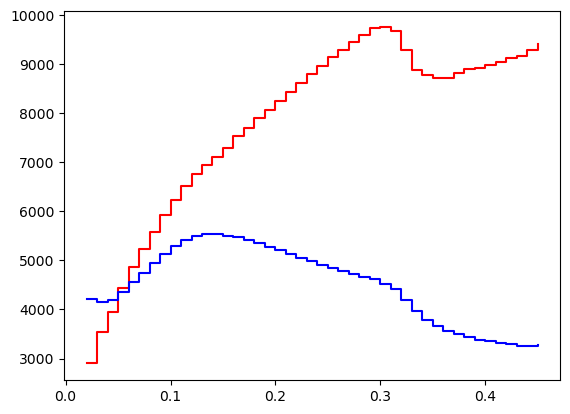

In [343]:
sim_hits = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
for i,name in enumerate(mod_names):
    sim_hits[name].append(compute_hits(dist,dt,.02*u.s,.46*u.s,sims[name][0]))
    sim_hits[name].append(compute_hits(dist,dt,.02*u.s,.46*u.s,sims[name][1]))


plt.step(t[id5:id6], sim_hits['zha'][0], where='post',color='red',label='zha nh')
plt.step(t[id5:id6], sim_hits['zha'][1], where='post',color='blue',label='zha ih')

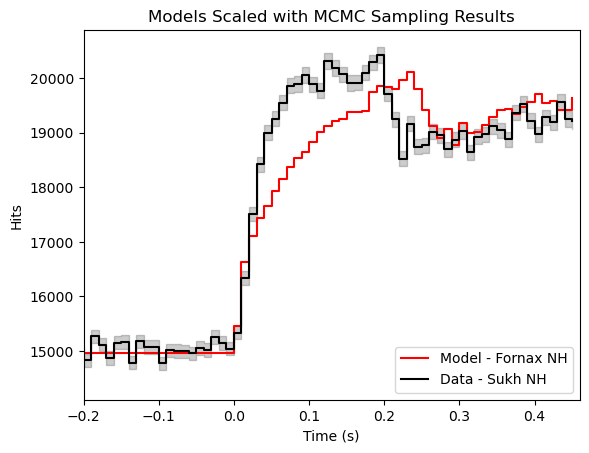

In [1280]:
dt=10*u.ms
data_hits=compute_hits_without_sub_bg(dist,dt,-1*u.s,.46*u.s,sims['sukh_sfho'][0])
sim_hits = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
for i,name in enumerate(mod_names):
    model0=compute_hits(dist,dt,-1*u.s,.46*u.s,sims[name][0])
    model1=compute_hits(dist,dt,-1*u.s,.46*u.s,sims[name][1])
    #sim_hits[name].append(compute_hits_scaled(5000/np.max(model0),dist,dt,.02*u.s,.46*u.s,sims[name][0]))
    #sim_hits[name].append(compute_hits_scaled(5000/np.max(model1),dist,dt,.02*u.s,.46*u.s,sims[name][1]))
    sim_hits[name].append(.486*compute_hits(dist,dt,-1*u.s,.46*u.s,sims[name][0]))
    sim_hits[name].append(.608*compute_hits(dist,dt,-1*u.s,.46*u.s,sims[name][1]))

plt.step(t[id5:id6], 14965+sim_hits['forn'][0], where='post',color='red',label='Model - Fornax NH')
#plt.step(t[id5:id6], 14925+sim_hits['forn'][1], where='post',color='blue',label='Forn IH')
plt.step(t[id5:id6], data_hits, where='post',color='black',label='Data - Sukh NH')
plt.fill_between(t[id5:id6], data_hits-np.sqrt(data_hits), data_hits+np.sqrt(data_hits),step='post',color='black', alpha=0.2)
plt.xlabel('Time (s)')
plt.xlim(-.2,.46)
plt.ylabel('Hits')
plt.title('Models Scaled with MCMC Sampling Results')
plt.legend(loc='lower right')

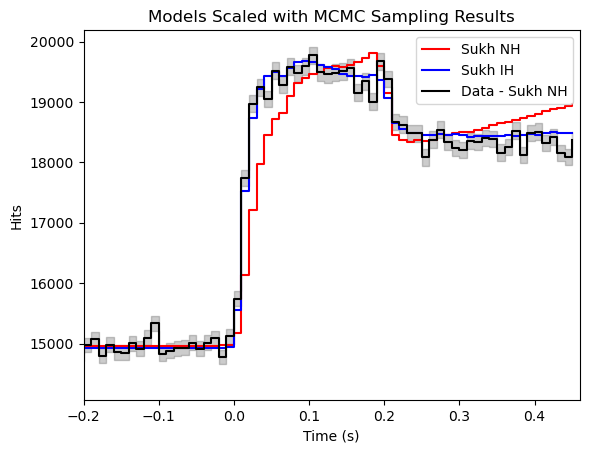

In [1157]:
dt=10*u.ms
data_hits=compute_hits_without_sub_bg(dist,dt,-1*u.s,.46*u.s,sims['sukh_sfho'][1])
sim_hits = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
for i,name in enumerate(mod_names):
    model0=compute_hits(dist,dt,-1*u.s,.46*u.s,sims[name][0])
    model1=compute_hits(dist,dt,-1*u.s,.46*u.s,sims[name][1])
    #sim_hits[name].append(compute_hits_scaled(5000/np.max(model0),dist,dt,.02*u.s,.46*u.s,sims[name][0]))
    #sim_hits[name].append(compute_hits_scaled(5000/np.max(model1),dist,dt,.02*u.s,.46*u.s,sims[name][1]))
    sim_hits[name].append(.9*compute_hits(dist,dt,-1*u.s,.46*u.s,sims[name][0]))
    sim_hits[name].append(1.02*compute_hits(dist,dt,-1*u.s,.46*u.s,sims[name][1]))

plt.step(t[id5:id6], 14965+sim_hits['sukh_sfho'][0], where='post',color='red',label='Sukh NH')
plt.step(t[id5:id6], 14925+sim_hits['sukh_sfho'][1], where='post',color='blue',label='Sukh IH')
plt.step(t[id5:id6], data_hits, where='post',color='black',label='Data - Sukh NH')
plt.fill_between(t[id5:id6], data_hits-np.sqrt(data_hits), data_hits+np.sqrt(data_hits),step='post',color='black', alpha=0.2)
plt.xlabel('Time (s)')
plt.xlim(-.2,.46)
plt.ylabel('Hits')
plt.title('Models Scaled with MCMC Sampling Results')
plt.legend()

In [13]:
def compute_probs_norm(data_sim,model_sims,priors,dist,dt,hierarchy,errs):
    probs=[]
    mod_names=model_sims.keys()
    sim_hits = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
    for i,name in enumerate(mod_names):
        sim_hits[name].append(compute_hits_norm(dist,dt,.02*u.s,.46*u.s,model_sims[name][0]))
        sim_hits[name].append(compute_hits_norm(dist,dt,.02*u.s,.46*u.s,model_sims[name][1]))
    for j in range(errs):
        data_hits,data_unnorm=compute_hits_with_bg_norm(dist,dt,.02*u.s,.46*u.s,data_sim)
        prob=0
        for k,name in enumerate(mod_names):
            print(compute_chi_sq_norm(sim_hits[name][0],data_hits,data_unnorm,dt,data_sim))
            p_d_nh=np.exp(-.5*compute_chi_sq_norm(sim_hits[name][0],data_hits,data_unnorm,dt,data_sim))
            p_d_ih=np.exp(-.5*compute_chi_sq_norm(sim_hits[name][1],data_hits,data_unnorm,dt,data_sim))
            if(hierarchy==0):
                prob+= p_d_nh/(p_d_nh+p_d_ih)*priors[k]
            else:
                prob+= p_d_ih/(p_d_ih+p_d_nh)*priors[k]
        probs.append(prob)
    return probs

In [14]:
def compute_probs_scaled(data_sim,model_sims,priors,dist,dt,hierarchy,errs):
    probs=[]
    mod_names=model_sims.keys()
    
    for j in range(errs):
        data_hits=compute_hits_with_bg(dist,dt,.02*u.s,.46*u.s,data_sim)
        prob=0
        sim_hits = {
            'sukh_sfho': [],
            'sukh_ls220': [],
            'forn': [],
            'zha': [],
            'tamb': []
        }
        for k,name in enumerate(sim_hits.keys()):
            model0=compute_hits(dist,dt,.02*u.s,.46*u.s,sims[name][0])
            model1=compute_hits(dist,dt,.02*u.s,.46*u.s,sims[name][1])
            sim_hits[name].append(compute_hits_scaled(np.max(data_hits)/np.max(model0),dist,dt,.02*u.s,.46*u.s,model_sims[name][0]))
            sim_hits[name].append(compute_hits_scaled(np.max(data_hits)/np.max(model1),dist,dt,.02*u.s,.46*u.s,model_sims[name][1]))

            p_d_nh=np.exp(-.5*compute_chi_sq(sim_hits[name][0],data_hits,dt,data_sim))
            p_d_ih=np.exp(-.5*compute_chi_sq(sim_hits[name][1],data_hits,dt,data_sim))
            
            if(hierarchy==0):
                prob+= p_d_nh/(p_d_nh+p_d_ih)*priors[k]
            else:
                prob+= p_d_ih/(p_d_ih+p_d_nh)*priors[k]
        probs.append(prob)
    return probs

In [15]:
def scale_integrand(scale, data, model_sim, dt, a, b):
    scaled_model=compute_hits_scaled(scale,dist,dt,.02*u.s,.46*u.s,model_sim)
    
    return np.exp(-.5*compute_chi_sq(scaled_model,data,dt,model_sim)+np.log(1/(b-a)))

In [16]:
def integrand_poisson(beta, bg, model_hits, data_hits, bmin, bmax, betamin, betamax):
    integrand=np.exp(log_likelihood_poisson(bg,beta,model_hits,
                                            data_hits))*(1/(betamax-betamin))*(1/(bmax-bmin))
    #integrand=np.exp(log_likelihood_norm_approx(bg,beta,model_hits,data_hits))*(1/(betamax-betamin))*(1/(bmax-bmin))
    #integrand=np.exp(log_likelihood_norm_approx(bg,beta,model_hits,data_hits))
    return integrand

In [17]:
def log_prob_poisson(theta, model_hits, data_hits, betamin, betamax, bmin, bmax):
    beta,bg=theta
    
    if bmin <= bg <= bmax and betamin <= beta <= betamax:
        log_prior = 0
        return log_likelihood_poisson(bg, beta, model_hits, data_hits) + log_prior
    
    return -np.inf 

In [18]:
def compute_log_integral(data_hits,model_sim,dist,dt):
    model_hits=compute_hits(dist,dt,-.5*u.s,.46*u.s,model_sim)
    
    betamin=0
    betamax=30000/np.max(model_hits)
    
    self=model_sim.detector
    bg_mean= self.i3_dom_bg_mu * dt.to(u.s).value * self.n_i3_doms + self.dc_dom_bg_mu * dt.to(u.s).value * self.n_dc_doms
    bg_var= (self.i3_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_i3_doms))**2 + (self.dc_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_dc_doms))**2
    bg_sig=np.sqrt(bg_var)
    
    bmin= bg_mean-3*bg_sig
    bmax= bg_mean+3*bg_sig
    
    ndim = 2
    nwalkers = 32
    
    bminguess= bg_mean-1*bg_sig
    bmaxguess= bg_mean+1*bg_sig

    initial_positions = np.random.uniform([betamin, bminguess], [betamax, bmaxguess], (nwalkers, ndim))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_poisson, args=(model_hits, data_hits, betamin, betamax, bmin, bmax))

    nsteps = 1000
    sampler.run_mcmc(initial_positions, nsteps)

    burn_in = 100
    samples = sampler.get_chain(discard=burn_in, flat=True)
    
    logprob=[log_prob_poisson((beta,b), model_hits, data_hits, betamin, betamax, bmin, bmax) for beta,b in samples]
    print(logprob[:10])
    
    bs=samples[:,0]
    betas=samples[:,1]
    integration_area=(np.max(bs)-np.min(bs))*(np.max(betas)-np.min(betas))
    logint=np.log(integration_area/len(samples[:,0]))+logsumexp(logprob)

    return logint

In [19]:
samples[:,1]

NameError: name 'samples' is not defined

In [ ]:
def log_probs_with_poisson(data_sim,model_sims,priors,dist,dt,hierarchy,errs):
    log_probs_nh=[]
    log_probs_ih=[]
    for j in tqdm(range(errs)):
        data_hits=compute_hits_without_sub_bg(dist,dt,-.5*u.s,.46*u.s,data_sim)
        log_prob_nh=[]
        log_prob_ih=[]
        for k,name in enumerate(model_sims.keys()):
            if(priors[k]!=0):
                log_p_d_nh=compute_log_integral(data_hits,model_sims[name][0],dist,dt)
                log_p_d_ih=compute_log_integral(data_hits,model_sims[name][1],dist,dt)
                print(name, log_p_d_nh,log_p_d_ih)
                
                log_prob_nh.append(log_p_d_nh-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(priors[k]))
                log_prob_ih.append(log_p_d_ih-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(priors[k]))
        prob_nh=logsumexp(log_prob_nh)
        prob_ih=logsumexp(log_prob_ih)
        
        log_probs_nh.append(prob_nh)
        log_probs_ih.append(prob_ih)
            
    return log_probs_nh, log_probs_ih

In [20]:
def log_probs_with_poisson_mult_priors(data_sim,model_sims,priors,dist,dt,hierarchy,errs):
    log_ratios=[]
    for j in tqdm(range(errs)):
        data_hits=compute_hits_without_sub_bg(dist,dt,-.5*u.s,.46*u.s,data_sim)
        log_prob_nh=[]
        log_prob_ih=[]
        log_ratio=[]
        for k,name in enumerate(model_sims.keys()):
            log_p_d_nh=compute_log_integral(data_hits,model_sims[name][0],dist,dt)
            log_p_d_ih=compute_log_integral(data_hits,model_sims[name][1],dist,dt)
            log_prob_nh.append(log_p_d_nh)
            log_prob_ih.append(log_p_d_ih)
 
        for i,prior in enumerate(priors):   
            p_nh=[]
            p_ih=[]
            for k,pro in enumerate(log_prob_nh):
                log_p_d_nh=pro
                log_p_d_ih=log_prob_ih[k]
                
                p_nh.append(log_p_d_nh-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(prior[k]))
                p_ih.append(log_p_d_ih-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(prior[k]))

            print(p_nh,p_ih)
            prob_nh=logsumexp(p_nh)
            prob_ih=logsumexp(p_ih)
            
            if(hierarchy==0):
                log_ratio.append(prob_nh-prob_ih)
            else:
                log_ratio.append(prob_ih-prob_nh)
        log_ratios.append(log_ratio)
            
    return log_ratios

In [21]:
def log_likelihood_poisson(bg,scale,model_hits,data_hits):
    result=0
    for i in range(len(model_hits)):
        result+=data_hits[i]*np.log(bg+scale*model_hits[i])-bg-scale*model_hits[i]-lgamma(data_hits[i]+1)
    return result

In [448]:
data=compute_hits_with_bg(dist,dt,.02*u.s,.46*u.s, sims['sukh_ls220'][0])
compute_prob_with_scale(data,sims['sukh_ls220'][1],dt,dist)

1.4634774191786978e-128

In [884]:
bg_mean

14967.239999999998

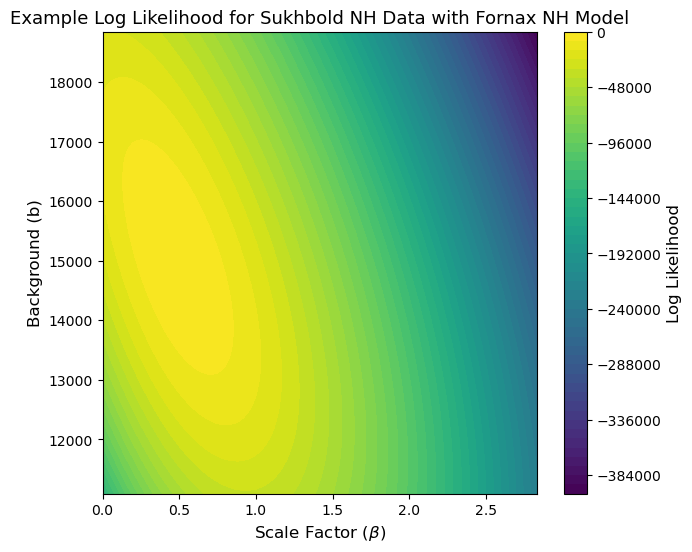

"\n\nresults=[]\nfor i,scale in enumerate(scale_values):\n    #result = integrand_poisson(scale, 15500, model, data, bmin,bmax,betamin,betamax)\n    result=log_likelihood_poisson(bg_mean,scale,model,data)\n    results.append(result)\n    \nresults_bg=[]\nfor i,bg in enumerate(bg_values):\n    #result = integrand_poisson(scale, 15500, model, data, bmin,bmax,betamin,betamax)\n    result=log_likelihood_poisson(bg,1.02,model,data)\n    results_bg.append(result)\n\n\n    \nplt.plot(bg_values,np.array(results_bg))\nprint(scales[np.argmax(results)])\n#print(bgs[np.argmax(results_bg)])\nprint(np.max(results))\n#plt.yscale('log')\nplt.xlabel('scale factor')\nplt.ylabel('likelihood')\n"

In [1263]:
dt=10*u.ms
dist=10*u.kpc
data=compute_hits_without_sub_bg(dist,dt,-.5*u.s,.46*u.s, sims['sukh_sfho'][0])
model=compute_hits(dist,dt,-.5*u.s,.46*u.s, sims['forn'][0])
model_sim=sims['sukh_sfho'][1]

    
betamin=0
betamax=30000/np.max(model)
    
self=model_sim.detector
bg_mean= self.i3_dom_bg_mu * dt.to(u.s).value * self.n_i3_doms + self.dc_dom_bg_mu * dt.to(u.s).value * self.n_dc_doms
bg_var= (self.i3_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_i3_doms))**2 + (self.dc_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_dc_doms))**2
bg_sig=np.sqrt(bg_var)
    
bmin= bg_mean-20*bg_sig
bmax= bg_mean+20*bg_sig


scale_values=np.linspace(betamin,betamax,100)
bg_values=np.linspace(bmin,bmax,100)

bg_grid, scale_grid = np.meshgrid(bg_values, scale_values)

# Evaluate the log-likelihood function on the grid
log_likelihood_grid = np.zeros_like(bg_grid)
for i in range(bg_grid.shape[0]):
    for j in range(bg_grid.shape[1]):
        log_likelihood_grid[i, j] = log_likelihood_poisson(bg_grid[i, j], scale_grid[i, j], model, data)

# Create the 2D plot
plt.figure(figsize=(7, 6))
contour = plt.contourf(scale_grid, bg_grid, log_likelihood_grid, cmap='viridis', levels=50)
cbar=plt.colorbar(contour)
cbar.set_label('Log Likelihood', fontsize=12)

# Add labels
plt.xlabel(r'Scale Factor ($\beta$)',fontsize=12)
plt.ylabel(r'Background (b)',fontsize=12)
plt.title(r'Example Log Likelihood for Sukhbold NH Data with Fornax NH Model',fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.show()


"""

results=[]
for i,scale in enumerate(scale_values):
    #result = integrand_poisson(scale, 15500, model, data, bmin,bmax,betamin,betamax)
    result=log_likelihood_poisson(bg_mean,scale,model,data)
    results.append(result)
    
results_bg=[]
for i,bg in enumerate(bg_values):
    #result = integrand_poisson(scale, 15500, model, data, bmin,bmax,betamin,betamax)
    result=log_likelihood_poisson(bg,1.02,model,data)
    results_bg.append(result)


    
plt.plot(bg_values,np.array(results_bg))
print(scales[np.argmax(results)])
#print(bgs[np.argmax(results_bg)])
print(np.max(results))
#plt.yscale('log')
plt.xlabel('scale factor')
plt.ylabel('likelihood')
"""


15549.075440653109

Text(0.5, 0.98, 'MCMC Results for Fornax NH Model')

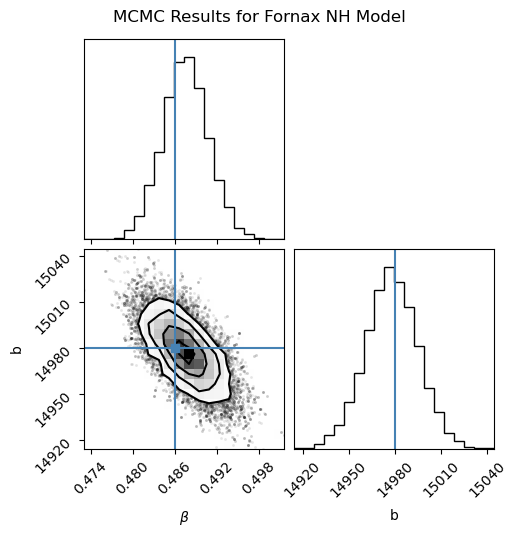

In [1275]:
import emcee
import corner
ndim = 2
nwalkers = 32

dist=10*u.kpc
dt=10*u.ms

#data=compute_hits_without_sub_bg(dist,dt,-.5*u.s,.46*u.s, sims['sukh_sfho'][1])
model=compute_hits(dist,dt,-.5*u.s,.46*u.s, sims['forn'][0])
model_sim=sims['sukh_ls220'][1]

    
betamin=0
betamax=30000/np.max(model)
    
self=model_sim.detector
bg_mean= self.i3_dom_bg_mu * dt.to(u.s).value * self.n_i3_doms + self.dc_dom_bg_mu * dt.to(u.s).value * self.n_dc_doms
bg_var= (self.i3_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_i3_doms))**2 + (self.dc_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_dc_doms))**2
bg_sig=np.sqrt(bg_var)
    
bmin= bg_mean-3*bg_sig
bmax= bg_mean+3*bg_sig

bminguess= bg_mean-1*bg_sig
bmaxguess= bg_mean+1*bg_sig

initial_positions = np.random.uniform([betamin, bmin], [betamax, bmax], (nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_poisson, args=(model, data, betamin, betamax, bmin, bmax))

nsteps = 1000
sampler.run_mcmc(initial_positions, nsteps)

burn_in = 100
samples = sampler.get_chain(discard=burn_in, flat=True)

fig = corner.corner(samples, labels=[r'$\beta$','b'], truths=[.486, 14980])
fig.suptitle('MCMC Results for Fornax NH Model')


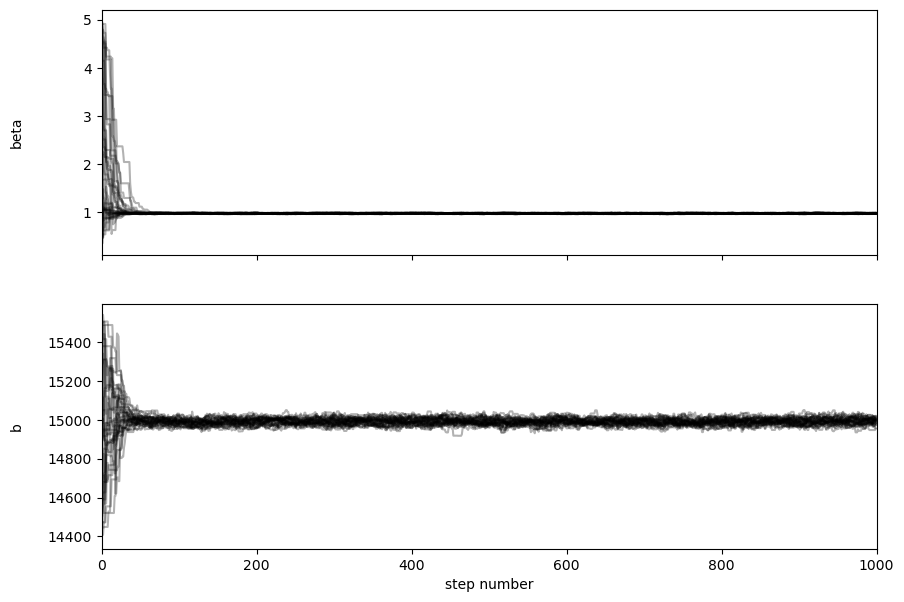

In [1175]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["beta", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [1062]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [12.20883623 23.42167299]

In [22]:
def probs_with_scale(data_sim,model_sims,priors,dist,dt,hierarchy,errs):
    probs=[]
    for j in range(errs):
        data_hits=compute_hits_with_bg_norm(dist,dt,.02*u.s,.46*u.s,data_sim)
        prob=0
        for k,name in enumerate(model_sims.keys()):
            p_d_nh=compute_prob_with_scale(data_hits,model_sims[name][0],dt,dist)
            p_d_ih=compute_prob_with_scale(data_hits,model_sims[name][1],dt,dist)
            if(hierarchy==0):
                prob+= p_d_nh/(p_d_nh+p_d_ih)*priors[k]
            else:
                prob+= p_d_ih/(p_d_ih+p_d_nh)*priors[k]
        probs.append(prob)
            
    return probs

In [23]:
def compute_odds_ratio(data_sim,model_sims,priors,dist,dt,hierarchy,errs):
    ratios=[]
    mod_names=model_sims.keys()
    sim_hits = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
    for i,name in enumerate(mod_names):
        sim_hits[name].append(compute_hits_norm(dist,dt,.02*u.s,.46*u.s,model_sims[name][0]))
        sim_hits[name].append(compute_hits_norm(dist,dt,.02*u.s,.46*u.s,model_sims[name][1]))
    for j in range(errs):
        data_hits=compute_hits_with_bg_norm(dist,dt,.02*u.s,.46*u.s,data_sim)
        prob_nh=0
        prob_ih=0
        for k,name in enumerate(mod_names):
            p_d_nh=np.exp(-.5*compute_chi_sq(sim_hits[name][0],data_hits,dt,data_sim))
            p_d_ih=np.exp(-.5*compute_chi_sq(sim_hits[name][1],data_hits,dt,data_sim))
            
            prob_nh += p_d_nh/(p_d_nh+p_d_ih)*priors[k]
            prob_ih += p_d_ih/(p_d_ih+p_d_nh)*priors[k]
        if(hierarchy==0):
            ratios.append(prob_nh/prob_ih)
        if(hierarchy==1):
            ratios.append(prob_ih/prob_nh)
    return ratios

In [24]:
def compute_p_val(area_tot,start,params,stat,chis_nh,bin_width):
    a,b=params
    upper=-1/a*(5000+b)
    lower=stat
    if(lower<start):
        area=len(chis_nh[np.logical_and(chis_nh>stat,chis_nh<start)])*bin_width+1/a*(np.exp(a*upper+b)-np.exp(a*start+b))
    else:
        area=1/a*(np.exp(a*upper+b)-np.exp(a*lower+b))
    area_full=.9*area_tot*bin_width + 1/a*(np.exp(a*upper+b)-np.exp(a*start+b))
    return area/area_full

In [25]:
def quad_fit(x, a, b):
    return a*x + b

In [26]:
def dist_to_pvals(data_sim,model_sims,priors,dist,dt,errs):
    
    
    probs_nh=compute_probs(data_sim,model_sims,priors,dist,dt,hierarchy=0,errs=errs)
    probs_ih=compute_probs(data_sim,model_sims,priors,dist,dt,hierarchy=1,errs=errs)

    probs_nh=np.array(probs_nh)
    probs_ih=np.array(probs_ih)
    
    if(np.median(probs_nh)<=np.median(probs_ih)):
        hist_nh, bin_edges_nh = np.histogram(probs_nh, bins=24)
        hist_ih, bin_edges_ih = np.histogram(probs_ih, bins=24)
        bin_width_nh = bin_edges_nh[1] - bin_edges_nh[0]

        cumulative_nh = np.cumsum(hist_nh)
        split_nh = np.searchsorted(cumulative_nh, .9*errs)

        tail_region_nh = slice(-(len(hist_nh)-split_nh), None)

        params_nh, cov_nh = curve_fit(quad_fit, bin_edges_nh[tail_region_nh], np.log(hist_nh[tail_region_nh]+1))
        a_nh, b_nh = params_nh

        p_vals=[]
        for i,prob_ih in enumerate(probs_ih):
            p=compute_p_val(errs,bin_edges_nh[split_nh],params_nh,prob_ih,probs_nh,bin_width_nh)
            p_vals.append(p)
            
        x_nh=np.linspace(bin_edges_nh[split_nh],
                         bin_edges_nh[split_nh]+.01,500)
        y_fit_nh = np.exp(a_nh*x_nh+b_nh)
        
        plt.hist(probs_nh, alpha=0.5, edgecolor='blue', 
                linewidth=1.5,label='NH',bins=16)
        plt.hist(probs_ih, alpha=0.5, color='red', edgecolor='red', 
                linewidth=1.5,label='IH',bins=16)
        plt.plot(x_nh, y_fit_nh, color='blue', label='NH fit')

        return -1*np.array([norm.isf(np.median(p_vals)),
                    norm.isf(np.percentile(p_vals, 16)),
                    norm.isf(np.percentile(p_vals, 84))])
        #return norm.isf(np.median(p_vals))
    else:
        hist_nh, bin_edges_nh = np.histogram(probs_nh, bins=24)
        hist_ih, bin_edges_ih = np.histogram(probs_ih, bins=24)
        bin_width_ih = bin_edges_ih[1] - bin_edges_ih[0]

        cumulative_ih = np.cumsum(hist_ih)
        split_ih = np.searchsorted(cumulative_ih, .9*errs)

        tail_region_ih = slice(-(len(hist_ih)-split_ih), None)

        params_ih, cov_ih = curve_fit(quad_fit, bin_edges_ih[tail_region_ih], np.log(hist_ih[tail_region_ih]+1))
        a_ih, b_ih = params_ih

        p_vals=[]
        for i,prob_nh in enumerate(probs_nh):
            p=compute_p_val(errs,bin_edges_ih[split_ih],params_ih,prob_nh,probs_ih,bin_width_ih)
            p_vals.append(p)
            
        x_ih=np.linspace(bin_edges_ih[split_ih],
                         bin_edges_ih[split_ih]+.01,500)
        y_fit_ih = np.exp(a_ih*x_ih+b_ih)
        
        plt.hist(probs_nh, alpha=0.5, edgecolor='blue', 
                linewidth=1.5,label='NH',bins=16)
        plt.hist(probs_ih, alpha=0.5, color='red', edgecolor='red', 
                linewidth=1.5,label='IH',bins=16)
        plt.plot(x_ih, y_fit_ih, color='red', label='IH fit')

        return np.array([norm.isf(np.median(p_vals)),
                    norm.isf(np.percentile(p_vals, 16)),
                    norm.isf(np.percentile(p_vals, 84))])
        #return -1*norm.isf(np.median(p_vals))

In [998]:
logsumexp([-722.5528034331983,logsumexp([-722.5528034331983,-1014.9024942636023])])

-721.8596562526384

In [1148]:
logsumexp([-99.4424696334237+np.log(.9),-750+np.log(.02),-15000+np.log(.02),-13000+np.log(.02),-5000+np.log(.02)])

-99.54783014908152

In [1150]:
logsumexp([np.log(.9),np.log(.02),np.log(.02),np.log(.02),np.log(.02)])

-0.02020270731751972

In [1151]:
np.log(.9)

-0.10536051565782628

Text(0.5, 1.0, 'Log Probabilities for Unequal Priors')

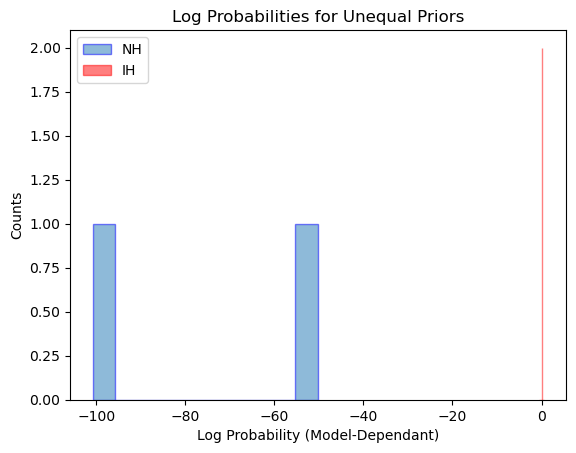

In [1229]:
from scipy.special import logsumexp
data_sim=sims['sukh_sfho'][1]
priors=[.2,.2,.2,.2,.2]
#priors=[1,0,0,0,0]
probs_nh, probs_ih=log_probs_with_poisson(sims['sukh_sfho'][1],sims,priors,10*u.kpc,10*u.ms,hierarchy=0,errs=2)

plt.hist(probs_nh,alpha=.5,edgecolor='blue',label='NH')
plt.hist(probs_ih,color='red',alpha=.5,edgecolor='red',label='IH')
plt.legend()
#plt.xscale('log')
plt.xlabel('Log Probability (Model-Dependant)')
plt.ylabel('Counts')
plt.title('Log Probabilities for Unequal Priors')

In [31]:
prior_list=np.linspace(.2,.99,100)
ratios_ih={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }

for i,mod_name in enumerate(ratios_ih.keys()):
    all_priors=[]
    for j,prior in enumerate(prior_list):
        priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
        priors[i]=prior
        all_priors.append(priors)
    mod_ratios=log_probs_with_poisson_mult_priors(sims[mod_name][1],sims,all_priors,10*u.kpc,10*u.ms,hierarchy=1,errs=1)
    ratios_ih[mod_name].append(mod_ratios)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-935.7147359561932, -935.632876096468, -935.8692725526635, -935.8801731155982, -935.584650474033, -935.5135023740877, -939.2336491215246, -937.501979088076, -935.7237623717228, -936.6218178648996]
[-651.068423709643, -652.7900715719588, -651.3669926717266, -651.3017531675432, -651.461653652339, -651.620127629576, -652.0908939458604, -651.3032353552844, -651.5618577319401, -651.6720447924308]
[-1242.8242542585067, -1242.9133742396225, -1242.7565237214003, -1243.2695243223425, -1242.7538200678537, -1243.485317689585, -1248.016339664784, -1244.7898530342936, -1243.060723679766, -1242.8360598861327]
[-777.2681765453599, -777.1721428583987, -777.246432254673, -777.7207038457273, -778.7206196939369, -777.8241760232777, -780.8430286734365, -778.9429086100281, -778.1749759472877, -777.7349115216639]
[-1619.2292380493018, -1618.856932693423, -1618.9019360461098, -1619.442966044022, -1619.8131767157756, -1618.8851166135282, -1620.6600232050114, -1621.0245047729113, -1619.4204739779816, -1619.14

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [05:02<00:00, 302.79s/it]


[-919.4931215252873, -919.4803308076371, -920.6163580921566, -920.6954753191822, -919.6133589497913, -920.0666613476496, -921.0841357950558, -922.3457230409986, -919.9114141541213, -919.690780373101]
[-286.307552436609, -467.3626518021601, -504.6204334754546, -1425.955526983762, -543.6057673507565] [-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003]
[-286.2684288532698, -467.37267663073766, -504.6304583040322, -1425.9655518123395, -543.615792179334] [-1.5703143290948918, -1.61946274101165, -1.61946274101165, -1.61946274101165, -1.61946274101165]
[-286.23077846871263, -467.38280297503974, -504.64058464833425, -1425.9756781566416, -543.6259185236361] [-1.5326639445376908, -1.6295890853137203, -1.6295890853137203, -1.6295890853137203, -1.6295890853137203]
[-286.1944943506813, -467.3930329121009, -504.65081458539544, -1425.9859080937028, -543.6361484606973] [-1.49637982650637, -1.639819022374937, -1.639819022374937, -1.639819022374937, 

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-897.0581160787988, -896.5999621111259, -896.2099422937463, -896.0466965102969, -896.857273947564, -896.0439071634028, -896.1462739731796, -896.6841842298891, -896.5231538554071, -897.0327329830761]
[-749.3659092236921, -749.0764640406414, -748.4876712282712, -747.4099512367975, -747.76266887768, -748.1292230790132, -748.3441805078182, -747.7132055980474, -749.8024302734848, -748.2871577504702]
[-1097.5804307337676, -1097.3442235454859, -1097.819294850895, -1097.6180693704518, -1097.4479257131316, -1097.4899620242359, -1097.3136258905433, -1098.0089397643314, -1097.7532881307852, -1098.4287533176976]
[-638.6150174008362, -638.4116268519429, -639.813166602733, -637.8893706692324, -640.2079393803288, -637.8047123711585, -637.6000472824962, -637.9940631818754, -639.5843962453655, -638.4690715466713]
[-1973.4744809795375, -1973.578601358473, -1973.1692957807682, -1974.1741748892382, -1973.1800758332538, -1973.246940090874, -1974.5479452201107, -1973.1802129526914, -1973.5148065511894, -19

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [05:00<00:00, 300.60s/it]


[-992.8239241895935, -992.650284656338, -992.3392569522985, -994.2847373056429, -992.7637995256373, -994.2188914517319, -993.6530802873458, -995.0443209763471, -993.1611376419751, -993.4891852131259]
[-150.50733947983525, -461.2773047333464, -445.71080472529735, -1696.6259156799972, -561.7796879463715] [-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003]
[-150.51736430841282, -461.2381811500072, -445.7208295538749, -1696.6359405085748, -561.789712774949] [-1.61946274101165, -1.5703143290948918, -1.61946274101165, -1.61946274101165, -1.61946274101165]
[-150.52749065271487, -461.20053076545, -445.730955898177, -1696.6460668528769, -561.799839119251] [-1.6295890853137203, -1.5326639445376908, -1.6295890853137203, -1.6295890853137203, -1.6295890853137203]
[-150.53772058977611, -461.1642466474187, -445.7411858352382, -1696.656296789938, -561.8100690563123] [-1.639819022374937, -1.49637982650637, -1.639819022374937, -1.639819022374937, -1.

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1965.3180273113248, -1965.4063345255709, -1967.215539246201, -1966.535925659773, -1965.0538433930633, -1965.6350880736281, -1965.035777536541, -1967.0695356443612, -1964.9765013287106, -1966.9140221627895]
[-2006.9493382508954, -2001.4618950529693, -2001.563747856184, -2002.792148816763, -2002.1612719941331, -2002.4997655124025, -2004.8546757057047, -2002.9490617401607, -2001.8028366639337, -2001.4637240126467]
[-2645.250119420816, -2646.252703804639, -2645.3370800243138, -2645.3916240467224, -2645.6866776257666, -2647.0621531463694, -2646.3358124785736, -2645.8202385277546, -2645.2370382145164, -2646.322610854928]
[-2806.1503215745324, -2804.615152719838, -2807.2624346456723, -2804.238473317557, -2803.780575340352, -2803.7420694521425, -2806.8478571867017, -2804.906346277363, -2804.3803521741356, -2805.9297507256997]
[-1313.9329104567587, -1312.9918415231368, -1315.0383453492832, -1315.3417434164003, -1313.7029995415069, -1314.715461913991, -1313.5853013732558, -1313.7807938196784, 

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:57<00:00, 297.44s/it]


[-1412.2437935259659, -1411.9161108773842, -1412.3615480733133, -1412.9730631018174, -1412.4849083470035, -1413.1579219012638, -1412.1651860744169, -1412.9586947723292, -1411.8455088909395, -1411.7961611829815]
[-1.6094379124341003, -1.6094379124341003, -649.5573361777537, -559.8932955370373, -635.5394575342137] [-38.164113440903364, -160.1596709652493, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003]
[-1.61946274101165, -1.61946274101165, -649.5182125944144, -559.9033203656147, -635.5494823627912] [-38.17413826948091, -160.16969579382686, -1.5703143290948918, -1.61946274101165, -1.61946274101165]
[-1.6295890853137203, -1.6295890853137203, -649.4805622098572, -559.9134467099168, -635.5596087070933] [-38.18426461378298, -160.1798221381289, -1.5326639445376908, -1.6295890853137203, -1.6295890853137203]
[-1.639819022374937, -1.639819022374937, -649.4442780918258, -559.923676646978, -635.5698386441545] [-38.1944945508442, -160.19005207519015, -1.49637982650637, -1.63981902237

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1890.704184000002, -1888.881891551544, -1888.562160175119, -1891.5267440976604, -1888.4059849733167, -1888.6014581404452, -1888.7718420623132, -1889.0413923629967, -1888.493723773834, -1888.8220354217774]
[-1334.4999514592491, -1334.5561040742614, -1337.7446491108713, -1336.3740854934877, -1334.66701814314, -1338.389815006376, -1334.461201487502, -1334.4101531549677, -1334.4109426518553, -1334.5288737384835]
[-2377.2792831789993, -2377.3888791902573, -2377.5487104608037, -2377.2330614855164, -2377.283662825852, -2377.2884126952413, -2377.3435266104498, -2379.645270933004, -2377.186609947268, -2379.086625598051]
[-1675.150176494164, -1674.5995824161218, -1675.604746156896, -1678.055976221629, -1675.132733267761, -1674.84752981388, -1675.1431837500713, -1675.8917105313158, -1674.6077830669237, -1674.853915440166]
[-2354.7890787931974, -2355.331119695911, -2355.146816441047, -2357.3107885395148, -2354.748198486952, -2356.294102993197, -2354.886656698931, -2354.6499675779196, -2355.17828

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [28:21<00:00, 1701.49s/it]


[-1562.636917625554, -1564.0808558022545, -1564.8210877730744, -1563.0819734848628, -1562.9097182509431, -1564.0054009431915, -1562.7402129839465, -1562.4842804452055, -1562.93211884037, -1563.0818635252072]
[-555.6092376453629, -704.4079708595524, -896.8149892108225, -2798.4490101921842, -719.5998489421412] [-1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003]
[-555.6192624739404, -704.4179956881298, -896.8250140394, -2798.4098866088448, -719.6098737707187] [-1.61946274101165, -1.61946274101165, -1.61946274101165, -1.5703143290948918, -1.61946274101165]
[-555.6293888182424, -704.4281220324319, -896.8351403837021, -2798.3722362242875, -719.6200001150207] [-1.6295890853137203, -1.6295890853137203, -1.6295890853137203, -1.5326639445376908, -1.6295890853137203]
[-555.6396187553037, -704.4383519694932, -896.8453703207633, -2798.335952106256, -719.630230052082] [-1.639819022374937, -1.639819022374937, -1.639819022374937, -1.49637982650637,

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-879.0842514110118, -879.0646624728688, -879.9033734955156, -880.1269289171614, -880.5954790476244, -880.0417160607321, -880.4077904334699, -879.4349855817563, -879.5705823127646, -879.730442496395]
[-1086.3503900845535, -1087.3757576351782, -1087.083497460917, -1087.2148339280102, -1088.8651140492293, -1086.3177983448404, -1086.3228129706986, -1086.414647499958, -1087.5755999384855, -1088.520610987136]
[-1263.6302466970956, -1262.0713269693224, -1262.9894931886374, -1261.9273881133558, -1261.9649483290268, -1264.5249250046618, -1261.9752431332745, -1262.140931193775, -1262.0298310552462, -1267.2972060559114]
[-1259.3076577525062, -1259.5203473958536, -1259.6043250414514, -1259.7582444069994, -1259.1157862690743, -1260.9165125411528, -1259.2455940656218, -1259.347800012838, -1260.472097299731, -1259.2441307255503]
[-1314.5489536069072, -1314.2457804548758, -1315.3223658142524, -1315.8120622291754, -1315.009542331769, -1314.9829331504297, -1314.279682837223, -1315.0214916449768, -1314.

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [05:04<00:00, 304.77s/it]

[-659.7944404581649, -660.0168397443922, -659.648570506135, -659.7563521023112, -659.871561199936, -659.8050971254415, -659.6499433249846, -660.3018011705572, -660.5565951115132, -660.0584811150766]
[-1.6094379124341003, -4.562782340882063, -238.33352659550593, -1015.8974002155427, -346.48242473413694] [-208.90718125148288, -1.6630127042333924, -1.6094379124341003, -1.6094379124341003, -1.6094379124341003]
[-1.61946274101165, -4.572807169459613, -238.3435514240835, -1015.9074250441201, -346.44330115079777] [-208.91720608006045, -1.6730375328109421, -1.61946274101165, -1.61946274101165, -1.5703143290948918]
[-1.6295890853137203, -4.582933513761683, -238.35367776838555, -1015.9175513884222, -346.40565076624057] [-208.9273324243625, -1.6831638771130124, -1.6295890853137203, -1.6295890853137203, -1.5326639445376908]
[-1.639819022374937, -4.5931634508229, -238.3639077054468, -1015.9277813254835, -346.3693666482092] [-208.93756236142374, -1.693393814174229, -1.639819022374937, -1.63981902237

In [32]:
np.savez('ih_ratios_many_priors.npz',ratios_ih)

In [1192]:
ratios_nh=np.load('sukh_sfho_nh_probs_1_iter.npz',allow_pickle=True)['arr_0']

In [1189]:
ratios

{'sukh_sfho': [[[226.35778460453713,
    225.95231949642897,
    225.66463742397718,
    225.441493872663,
    225.25917231586902,
    225.10502163604178,
    224.97149024341726,
    224.85370720776086]]],
 'sukh_ls220': [[[146.8345909574859,
    146.96812235011043,
    147.12227302993767,
    147.30459458673164,
    147.52773813804583,
    147.81542021049762,
    148.22088531860578,
    148.91403249916573]]],
 'forn': [[[0.4054651081081645,
    0.6190392084062236,
    0.8472978603872036,
    1.0986122886681096,
    1.3862943611198904,
    1.734601055388106,
    2.1972245773362196,
    2.9444389791664407]]],
 'zha': [[[571.4648796715688,
    571.5984110641933,
    571.7525617440206,
    571.9348833008145,
    572.1580268521287,
    572.4457089245806,
    572.8511740326887,
    573.5443212132486]]],
 'tamb': [[[0.4054651081081645,
    0.6190392084062236,
    0.8472978603872036,
    1.0986122886681096,
    1.3862943611198904,
    1.734601055388106,
    2.1972245773362196,
    2.944438979

In [1321]:
np.savez('sukh_sfho_nh_probs_5_iters.npz',probs_nh)
np.savez('sukh_sfho_ih_probs_5_iters.npz',probs_ih)

In [1034]:
probs_nh_old=np.load('sukh_sfho_nh_probs_5_iters.npz')['arr_0']
probs_ih_old=np.load('sukh_sfho_ih_probs_5_iters.npz')['arr_0']

In [1039]:
np.savez('sukh_sfho_nh_5_iters_prio9.npz',probs_nh)
np.savez('sukh_sfho_ih_5_iters_prio9.npz',probs_ih)

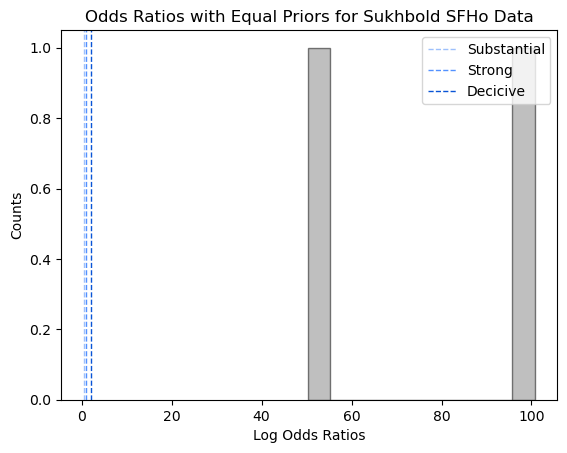

In [1133]:
probs_nh=np.array(probs_nh)
probs_ih=np.array(probs_ih)

plt.hist(probs_ih-probs_nh,alpha=.5,color='grey',edgecolor='black')
plt.xlabel('Log Odds Ratios')
plt.ylabel('Counts')
plt.title('Odds Ratios with Equal Priors for Sukhbold SFHo Data')
plt.axvline(x=.5, color='#9dc0fc', linestyle='--', linewidth=1,label='Substantial')
plt.axvline(x=1, color='#5291ff', linestyle='--', linewidth=1,label='Strong')
plt.axvline(x=2, color='#0954d6', linestyle='--', linewidth=1,label='Decicive')
plt.legend(loc='upper right')

(array([31.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0., 66.]),
 array([1.48984533e-50, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

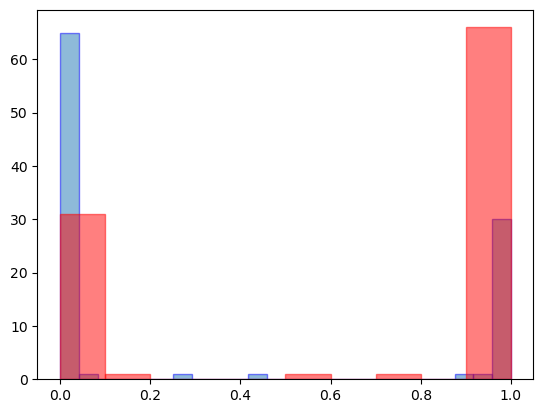

In [416]:
prob_nh=0
prob_ih=0

dist=10*u.kpc
dt=10*u.ms

prob_nh=[]
prob_ih=[]
name='tamb'
for i in range(100):
    data_hits=compute_hits_with_bg(dist,dt,.02*u.s,.46*u.s,sims['sukh_sfho'][0])
    
    model0=compute_hits(dist,dt,.02*u.s,.46*u.s,sims[name][0])
    model1=compute_hits(dist,dt,.02*u.s,.46*u.s,sims[name][1])
        
    sim_hits0=compute_hits_scaled(np.max(data_hits)/np.max(model0),dist,dt,.02*u.s,.46*u.s,sims[name][0])
    sim_hits1=compute_hits_scaled(np.max(data_hits)/np.max(model1),dist,dt,.02*u.s,.46*u.s,sims[name][1])
    

    p_d_nh= np.exp(-.5*compute_chi_sq(sim_hits0,data_hits,dt,sims[name][0]))
    p_d_ih=np.exp(-.5*compute_chi_sq(sim_hits1,data_hits,dt,sims[name][0]))
    
    prob_nh.append(p_d_nh/(p_d_nh+p_d_ih))
    prob_ih.append(p_d_ih/(p_d_ih+p_d_nh))
    ratios.append((p_d_nh/(p_d_nh+p_d_ih))/(p_d_ih/(p_d_ih+p_d_nh)))
    

plt.hist(prob_nh,alpha=.5,edgecolor='blue',bins=24)
plt.hist(prob_ih,color='red',alpha=.5,edgecolor='red')
#plt.xlim(0,.1)
#prob_nh

In [331]:
compute_prob_with_scale(data_sim,model_sim,dt,dist)

15001.553003653518

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 99.]),
 array([0.99999962, 0.99999966, 0.9999997 , 0.99999973, 0.99999977,
        0.99999981, 0.99999985, 0.99999989, 0.99999992, 0.99999996,
        1.        ]),
 <BarContainer object of 10 artists>)

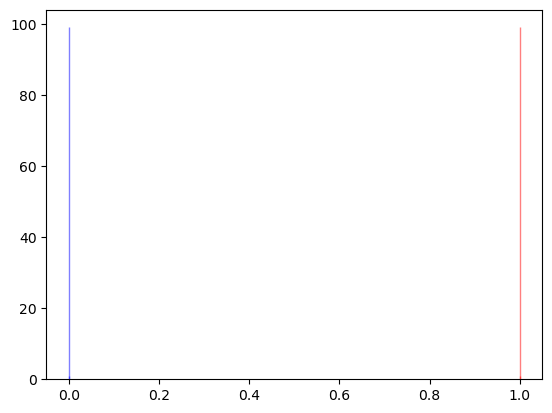

In [404]:
prob_nh=0
prob_ih=0

dist=10*u.kpc
dt=10*u.ms

prob_nh=[]
prob_ih=[]
for i in range(100):
    #data_hits=compute_hits_with_bg_norm(dist,dt,.02*u.s,.46*u.s,sims['sukh_sfho'][0])
    
    #sim_hits0=compute_hits_scaled(np.max(data_hits),dist,dt,.02*u.s,.46*u.s,sims['sukh_sfho'][0])
    #sim_hits1=compute_hits_scaled(np.max(data_hits),dist,dt,.02*u.s,.46*u.s,sims['sukh_sfho'][1])
    

    p_d_nh= compute_prob_with_scale(sims['sukh_sfho'][0],sims['forn'][0],dt,dist)
    p_d_ih= compute_prob_with_scale(sims['sukh_sfho'][0],sims['forn'][1],dt,dist)
    #print(p_d_nh)
    #print(p_d_ih)
    prob_nh.append(p_d_nh/(p_d_nh+p_d_ih))
    prob_ih.append(p_d_ih/(p_d_ih+p_d_nh))

    #ratios.append((p_d_nh/(p_d_nh+p_d_ih))/(p_d_ih/(p_d_ih+p_d_nh)))
    
#print(prob_nh,prob_ih)
plt.hist(prob_nh,alpha=.5,edgecolor='blue',bins=24)
plt.hist(prob_ih,color='red',alpha=.5,edgecolor='red')

In [239]:
compute_chi_sq(sim_hits1,data_hits)

0.12346140346146293

In [474]:
datas=[]
for i in range(1000):
    dat,unnorm_dat=compute_hits_with_bg_norm(dist,dt,.02*u.s,.46*u.s,sims['sukh_sfho'][0])
    datas.append(dat)
    
datas=np.array(datas)
np.var(datas[:,0])

1.0090215209276827e-06

In [475]:
1/37000

2.7027027027027027e-05

Text(0, 0.5, 'Counts')

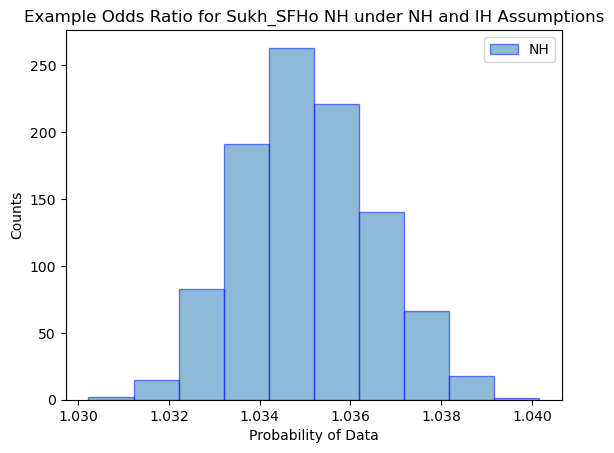

In [206]:
data_sim=sims['zha'][0]
priors=[1,1,1,1,1]
#priors=[.8,.05,.05,.05,.05]
ratios=compute_odds_ratio(data_sim,sims,priors,10*u.kpc,10*u.ms,hierarchy=0,errs=1000)

plt.hist(ratios,alpha=.5,edgecolor='blue',label='NH')
plt.legend()
plt.title('Example Odds Ratio for Sukh_SFHo NH under NH and IH Assumptions')
plt.xlabel('Probability of Data')
plt.ylabel('Counts')

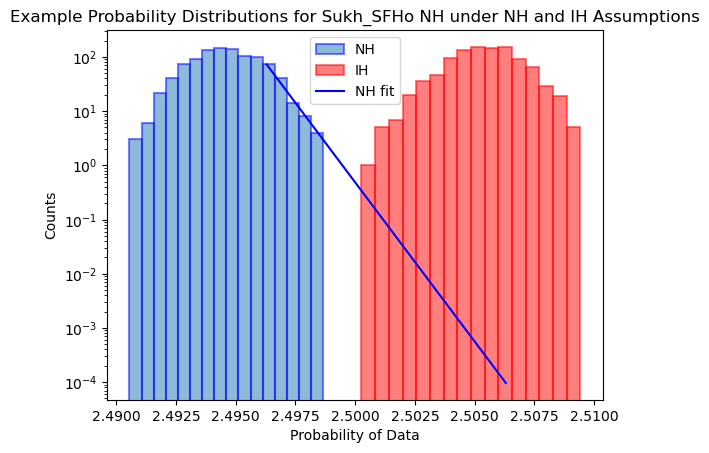

In [193]:
#priors=[,.05,.05,.05,.05]
dist_to_pvals(data_sim,sims,priors,10*u.kpc,10*u.ms,1000)
plt.legend()
plt.title('Example Probability Distributions for Sukh_SFHo NH under NH and IH Assumptions')
plt.xlabel('Probability of Data')
plt.ylabel('Counts')
plt.yscale('log')

array([5.54883651, 5.86618727, 5.22410699])

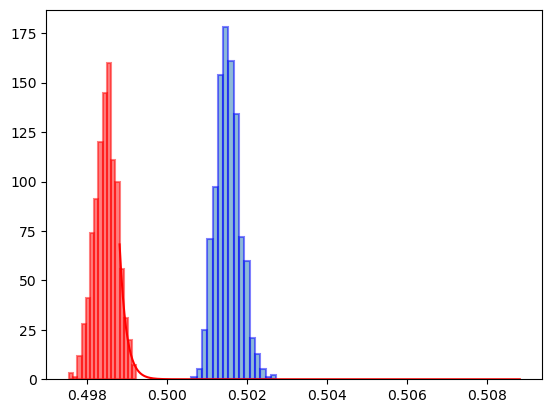

In [178]:
priors=[.9,.025,.025,.025,.025]
dist_to_pvals(data_sim,sims,priors,10*u.kpc,10*u.ms,1000)

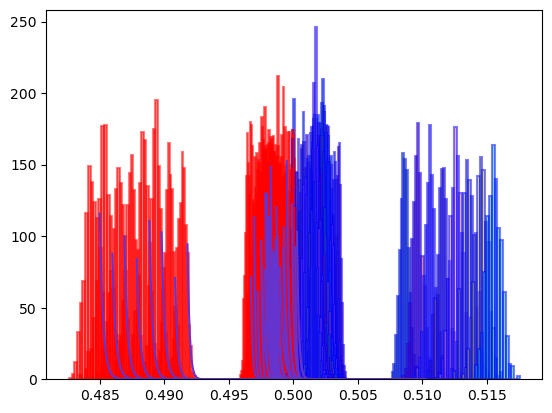

In [167]:
prior_list=np.linspace(.2,.9,8)
sigs={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
for i,mod_name in enumerate(sigs.keys()):
    for j,prior in enumerate(prior_list):
        priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
        priors[i]=prior
        p_vals_nh=dist_to_pvals(sims[mod_name][0],sims,priors,10*u.kpc,10*u.ms,1000)
        p_vals_ih=-1*dist_to_pvals(sims[mod_name][1],sims,priors,10*u.kpc,10*u.ms,1000)
        if(p_vals_ih[0]<p_vals_nh[0]):
            sigs[mod_name].append(p_vals_ih)
        else:
            sigs[mod_name].append(p_vals_nh)

Text(0, 0.5, 'Hierarchy Sensitivity')

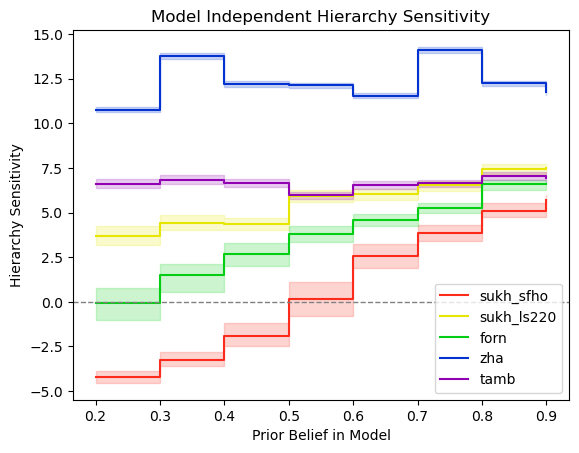

In [173]:
colors=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
for i,mod_name in enumerate(sigs.keys()):
    plt.step(prior_list,[meds[0] for meds in sigs[mod_name]],color=colors[i],where='post',label=mod_name)
    plt.fill_between(prior_list, [meds[1] for meds in sigs[mod_name]], 
                     [meds[2] for meds in sigs[mod_name]],step='post',color=colors[i], alpha=0.2)
plt.legend()
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title('Model Independent Hierarchy Sensitivity')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Hierarchy Sensitivity')

In [201]:
prior_list=np.linspace(.2,.9,8)
ratios={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
for i,mod_name in enumerate(sigs.keys()):
    for j,prior in enumerate(prior_list):
        priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
        priors[i]=prior
        ratios_nh=compute_odds_ratio(sims[mod_name][0],sims,priors,10*u.kpc,10*u.ms,0,1000)
        ratios_ih=compute_odds_ratio(sims[mod_name][1],sims,priors,10*u.kpc,10*u.ms,1,1000)
        if(np.median(ratios_ih)<np.median(ratios_nh)):
            ratios[mod_name].append([np.median(ratios_ih),
                    np.percentile(ratios_ih, 16),
                    np.percentile(ratios_ih, 84)])
        else:
            ratios[mod_name].append([np.median(ratios_nh),
                    np.percentile(ratios_nh, 16),
                    np.percentile(ratios_nh, 84)])

Text(0, 0.5, 'Odds Ratio')

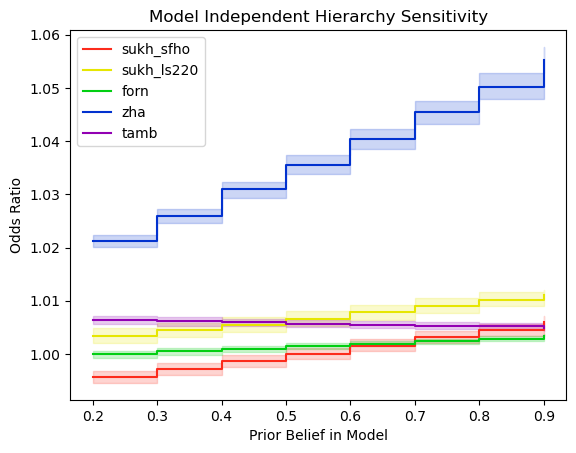

In [202]:
colors=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
for i,mod_name in enumerate(sigs.keys()):
    plt.step(prior_list,[meds[0] for meds in ratios[mod_name]],color=colors[i],where='post',label=mod_name)
    plt.fill_between(prior_list, [meds[1] for meds in ratios[mod_name]], 
                     [meds[2] for meds in ratios[mod_name]],step='post',color=colors[i], alpha=0.2)
plt.legend()
#plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title('Model Independent Hierarchy Sensitivity')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Odds Ratio')

$$
p(\mathbf{n}, \mathbf{E} \mid H_j, d,\hat{s}_k)  = p(\mathbf{n} \mid H_j, d,\hat{s}_k) p(\mathbf{E} \mid H_j, d,\hat{s}_k) 
$$

$$
p(\mathbf{E} \mid H_j, d,\hat{s}_k) = \frac{1}{\sqrt{2 \pi} \sigma_E} e^{(-.5\frac{E_i-\hat{E}_i}{\sigma_E})^2}
$$

$$
\ln \left[ p(\mathbf{n}\mid H_j, d,\hat{s}_k) \right]
\approx \ln \left[ \frac{(b_{max}-b_{min})(\beta_{max}-\beta_{min})}{N_{samples}} \sum_{\substack{b, \beta}} p(\mathbf{n}\mid H_j,d,b,\beta,\hat{s}_k) \right]
$$

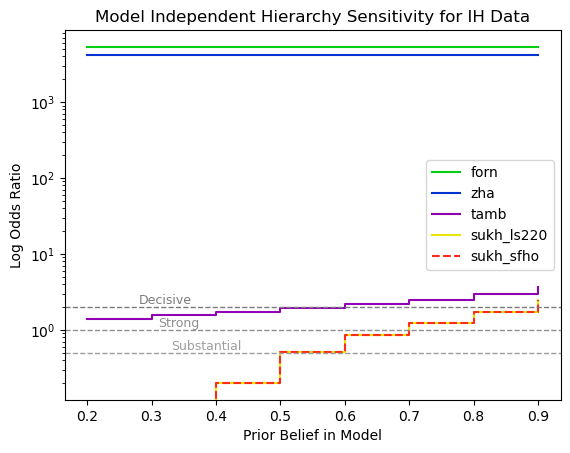

In [1307]:
colors=['#02cf13','#0232cf','#9200b3','#e6e602','#fc2b1c']
names=['forn','zha','tamb', 'sukh_ls220','sukh_sfho']
linestyles=['-','-','-','-','--']
for i,mod_name in enumerate(names):
    plt.step(prior_list,ratios_nh[mod_name][0][0],color=colors[i],where='post',label=mod_name, linestyle=linestyles[i])
plt.legend()
#plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title('Model Independent Hierarchy Sensitivity for NH Data')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Log Odds Ratio')
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.28,2.2,'Decisive',fontsize=9,color='#7B7B7B')
plt.text(.31,1.1,'Strong',fontsize=9,color='#8F8F8F')
plt.text(.33,.55,'Substantial',fontsize=9,color='#9E9E9E')
plt.yscale('log')

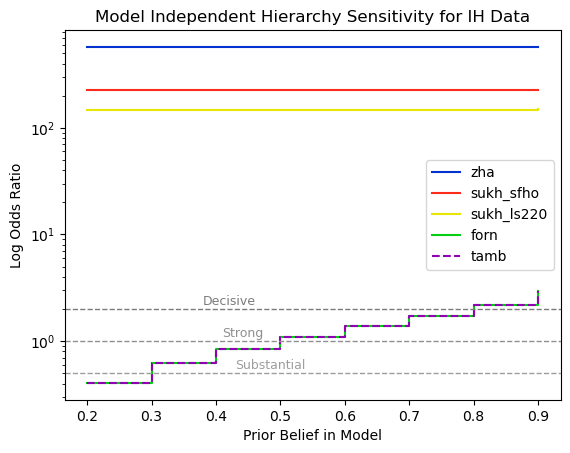

In [1310]:
colors=['#0232cf','#fc2b1c','#e6e602','#02cf13','#9200b3']
names=['zha','sukh_sfho', 'sukh_ls220','forn','tamb',]
linestyles=['-','-','-','-','--']
for i,mod_name in enumerate(names):
    plt.step(prior_list,ratios[mod_name][0][0],color=colors[i],where='post',label=mod_name, linestyle=linestyles[i])
plt.legend()
#plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title('Model Independent Hierarchy Sensitivity for IH Data')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Log Odds Ratio')
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.38,2.2,'Decisive',fontsize=9,color='#7B7B7B')
plt.text(.41,1.1,'Strong',fontsize=9,color='#8F8F8F')
plt.text(.43,.55,'Substantial',fontsize=9,color='#9E9E9E')
plt.yscale('log')

(400, 600)

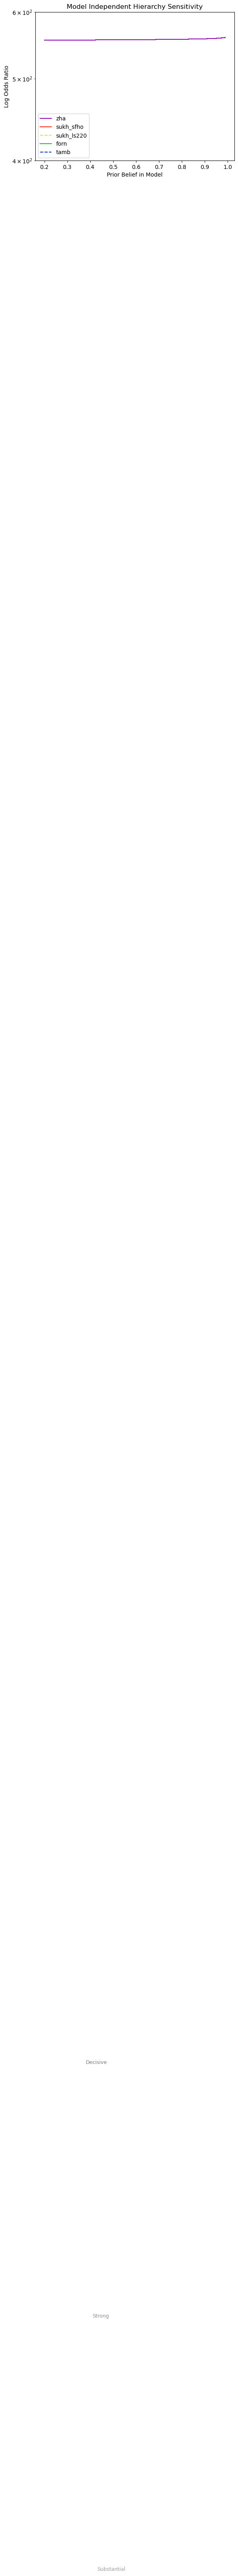

In [37]:
colors=['#9200b3','#fc2b1c','#e6e602','#02cf13','#0232cf']
labels=['zha','sukh_sfho', 'sukh_ls220', 'forn', 'tamb']
names=['zha','sukh_sfho', 'sukh_sfho', 'forn', 'forn']
linestyles=['-','-','--','-','--']
for i,mod_name in enumerate(names):
    if(ratios[mod_name][0][0][0]<ratios_ih[mod_name][0][0][0]):
        plt.step(prior_list,ratios[mod_name][0][0],color=colors[i],where='post',label=labels[i],linestyle=linestyles[i])
    else:
        plt.step(prior_list,ratios_ih[mod_name][0][0],color=colors[i],where='post',label=labels[i],linestyle=linestyles[i])
plt.legend()
#plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title('Model Independent Hierarchy Sensitivity')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Log Odds Ratio')
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.38,2.2,'Decisive',fontsize=9,color='#7B7B7B')
plt.text(.41,1.1,'Strong',fontsize=9,color='#8F8F8F')
plt.text(.43,.55,'Substantial',fontsize=9,color='#9E9E9E')
plt.yscale('log')
plt.ylim(400,600)

In [1218]:
sigs.keys()

dict_keys(['sukh_sfho', 'sukh_ls220', 'forn', 'zha', 'tamb'])